## Analysis of session-length of reading sessions

we consider the length of reading sessions as the number of pageviews in a reading session. A reading session are pageviews by the same [actor](https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Traffic/Pageview_actor) in which 2 consecutive pageviews happen within 1 hour. We collapse 2 consecutive views of the same page into one.

We analyze 1 week of reading sessions from English Wikipedia.

We look at differences between:
- access_method: desktop and mobile web
- topics
- location (continents)


In [1]:
import numpy as np
import matplotlib as mpl
import pylab as plt
%matplotlib inline 

mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [2]:
import os, sys
import datetime
import calendar
import time
import string
import random
import pandas as pd
import findspark
findspark.init('/usr/lib/spark2')
from pyspark.sql import SparkSession
from pyspark.sql import functions as F, types as T, Window
import wmfdata.spark as wmfspark

## defining the spark session
spark_config = {}
# regular
spark_config = {
    "spark.driver.memory": "2g",
    "spark.dynamicAllocation.maxExecutors": 64,
    "spark.executor.memory": "8g",
    "spark.executor.cores": 4,
    "spark.sql.shuffle.partitions": 256
}
# spark_config = {
#     "spark.driver.memory": "4g",
#     "spark.dynamicAllocation.maxExecutors": 128,
#     "spark.executor.memory": "8g",
#     "spark.executor.cores": 4,
#     "spark.sql.shuffle.partitions": 512
# }

os.environ['PYSPARK_DRIVER_PYTHON'] = 'notebook'
os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3.7'

spark = wmfspark.get_session(
    app_name='Pyspark notebook', 
    extra_settings=spark_config
)
spark

## Loading topics

topics for all wikipedia pages from: https://figshare.com/articles/Topics_for_each_Wikipedia_Article_across_Languages/12127434

copy to hive:

hdfs dfs -copyFromLocal -f topicsForAllWikipediaPages.csv /user/mgerlach/topicsForAllWikipediaPages.csv

In [3]:
filename_read = '/user/mgerlach/topicsForAllWikipediaPages.csv'
df_topics = spark.read.csv(filename_read,header=True)
df_topics.printSchema()

root
 |-- Qid: string (nullable = true)
 |-- topic: string (nullable = true)
 |-- probability: string (nullable = true)
 |-- page_id: string (nullable = true)
 |-- page_title: string (nullable = true)
 |-- wiki_db: string (nullable = true)



In [4]:
## only keep qids (get rid of page-id, page-title, wiki_db)
df_topics_qid = (
    df_topics
    .select(
        'Qid',
        'topic',
        'probability'
    )
    .distinct()
)

In [5]:
## only pick the most probable topic
df_topics_qid_agg = (
    df_topics_qid
    .where(F.col('probability')>0.5)
    .groupBy('Qid')
    .agg(
        F.array_sort(
            F.collect_list(
                F.struct(
                    F.lit(-1)*F.col('probability').cast('double'),
                    F.col('topic'),
                )
                
            )
        )[0].alias('maxprobtopic')
    )
    .select(
        F.col('Qid').alias('item_id'),
        F.col('maxprobtopic.topic').alias('topic')
    )
)

## Get reading sessions from webrequest logs

1 week of reading sessions 

In [21]:
## wiki_db ## seleecting wikidata gets pageviews from all wikis
## select a specific wiki_db for testing to reduce processing time, e.g. simplewiki
wiki_db = 'enwiki'
# wiki_db = 'simplewiki'

## timewindow
date_start = datetime.datetime(2020, 7, 1, 0)
# date_end = datetime.datetime(2020, 7, 1, 1)
# date_end = datetime.datetime(2020, 7, 2, 0)
date_end = datetime.datetime(2020, 7, 8, 0)
date_start_str = date_start.strftime('%Y-%m-%d-%H')
date_end_str = date_end.strftime('%Y-%m-%d-%H')

ts_start = calendar.timegm(date_start.timetuple())
ts_end = calendar.timegm(date_end.timetuple())
row_timestamp = F.unix_timestamp(F.concat(
    F.col('year'), F.lit('-'), F.col('month'), F.lit('-'), F.col('day'), 
    F.lit(' '), F.col('hour'), F.lit(':00:00')))

In [20]:
date_start.year

2020

In [8]:
## filter pageviews from actor with more than 500 pageviews per day
## the aim is to filter automated traffic that is not tagged as spider
w_p = Window.partitionBy(F.col('actor_signature_per_project_family'), F.col('year'), F.col('month'), F.col('day'))
n_p_max = 500 ## maximum number of pageviews/user/day
n_p_min = 1 ## minimum number of pageviews/user/day

In [9]:
df_actor = (
    spark.read.table('wmf.pageview_actor')
    .where(row_timestamp >= ts_start)
    .where(row_timestamp < ts_end)
    .where(F.col('is_pageview')==True)
    ## agent-type user to filter spiders
    ## https://meta.wikimedia.org/wiki/Research:Page_view/Tags#Spider
    .where(F.col('agent_type') == "user")
    ## user: desktop/mobile/mobile app; isaac filters != mobile app
    .where(F.col('access_method') != "mobile app")
    ## only wikis
    .where(F.col('normalized_host.project_family')=='wikipedia')
    ## only namespace 0
    .where( F.col('namespace_id') == 0 )
    .withColumn('wiki_db', F.concat(F.col('normalized_host.project'),F.lit('wiki')) )
)
## filter only specific wiki (or all if wiki_db=='wikidata')
if wiki_db == 'wikidata':
    pass
else:
    df_actor = df_actor.where(F.col('wiki_db')==wiki_db)
    
## filter maximum and minimum pageviews per user
## n_p is the number of pageviews per actor per day (across projects)
df_actor = (
    df_actor
    .withColumn('n_p', F.sum(F.lit(1)).over(w_p) )
    .where(F.col('n_p') >= n_p_min)
    .where(F.col('n_p') <= n_p_max)    
)
# df_tmp=df_actor.limit(10).toPandas()
# df_tmp.head()

In [10]:
## join the wikidata-item to each pageview
## we keep only pageviews for which we have a correpsionding wikidata-item id


## table with mapping wikidata-ids to page-ids
## partition wikidb and page-id ordered by snapshot
w_wd = Window.partitionBy(F.col('wiki_db'),F.col('page_id')).orderBy(F.col('snapshot').desc())
df_wd = (
    spark.read.table('wmf.wikidata_item_page_link')
    ## snapshot: this is a partition!
    .where(F.col('snapshot') >= '2020-07-01') ## resolve issues with non-mathcing wikidata-items
    ## only wikis (enwiki, ... not: wikisource)
    .where(F.col('wiki_db').endswith('wiki'))
)
## filter only specific wiki (or all if wiki_db=='wikidata')
if wiki_db == 'wikidata':
    pass
else:
    df_wd = df_wd.where(F.col('wiki_db')==wiki_db)
## get the most recent wikidata-item for each pid+wikidb
df_wd = (
    df_wd
    .withColumn('item_id_latest',F.first(F.col('item_id')).over(w_wd))
    .select(
        'wiki_db',
        'page_id',
        F.col('item_id_latest').alias('item_id')
    )
    .drop_duplicates()
)
df_actor_wd = (
    df_actor
    .join(
        df_wd,
        on = ['page_id','wiki_db'],
        how='inner'
    )
)

In [11]:
## join in the topics
df_actor_wd = (
    df_actor_wd
    .join(
        df_topics_qid_agg,
        on = ['item_id'],
        how='left'
    )
    
)

In [12]:
## aggregate all pageviews with same actor-signature across wikis
df_actor_wd_agg = (
    df_actor_wd
    .groupby('actor_signature_per_project_family')
    .agg(
#          F.first(F.col('access_method')).alias('access_method'), ## this could change along a session
#          F.first(F.col('geocoded_data')).alias('geocoded_data'),
#              F.first(F.col('n_p_by_user')).alias('session_length'),
         F.array_sort(
             F.collect_list(
                 F.struct(
                     F.col('ts'),
                     F.col('page_id'),
                     F.col('pageview_info.page_title').alias('page_title'),
                     F.col('wiki_db'),
                     F.col('item_id').alias('qid'),
                     F.col('topic'),
                     F.col('access_method'),
                     F.col('geocoded_data.continent').alias('continent'),
                     F.col('geocoded_data.country').alias('country'),
                     F.col('geocoded_data.city').alias('city'),
                 )
             )
         ).alias('session')
     )
)

In [22]:
##save as intermediate parquet file
FILE_out = '/user/mgerlach/sessions/session-length_%s_%s--%s.parquet'%(wiki_db,date_start_str,date_end_str)
df_actor_wd_agg.write.mode('overwrite').parquet(FILE_out)

## Filter reading sessions 

We apply additional filters
- remove pageviews without timestamp
- collapse consectuive views of the same article
- break sessions if consecutive pageviews are more than 1 hour apart.

In [40]:
## defining filter and maps
def parse_requests(requests):
    """
    do some initial parsing:
    - drop pages without timestamp (we dont know which order)
    - drop pages without pageid
    """
    requests_clean = []
    for r in requests:
        if r['ts'] == None or r['page_id']==None:
            pass
        else:
            requests_clean += [r]
    return requests_clean

def filter_consecutive_articles(requests):
    """
    Looking at the data, there are a lot of
    sessions with the same article
    requested 2 times in a row. This
    does not make sense for training, so
    lets collapse them into 1 request.
    We compare pageids
    """
    r = requests[0]
    t = r['page_id']
    clean_rs = [r,]
    prev_t = t
    if len(requests)>1:
        for r in requests[1:]:
            t = r['page_id']
            if t == prev_t:
                continue
            else:
                clean_rs.append(r)
                prev_t = t
    return clean_rs

# def filter_blacklist_qid(requests):
#     """
#     If the session contains an article in the blacklist,
#     drop the session. Currently, only the Main Page is
#     in the black list
#     """

#     black_list = set(['Q5296',])
#     for r in requests:
#         if r['qid'] in black_list:
#             return False
#     return True
   

def sessionize(requests, dt = 3600):
    """
    Break request stream whenever
    there is a gap larger than dt [secs] in requests.
    default is 3600s=1hour [from Halfaker et al. 2015]
    """
    sessions = []
    session = [requests[0]]
    for r in requests[1:]:
        d = r['ts'] -  session[-1]['ts']
        if d > datetime.timedelta(seconds=dt):
            sessions.append(session)
            session = [r,]
        else:
            session.append(r)

    sessions.append(session)
    return sessions    


In [35]:
FILE_in = '/user/mgerlach/sessions/session-length_%s_%s--%s.parquet'%(wiki_db,date_start_str,date_end_str)
df = spark.read.load(FILE_in)
df.printSchema()

root
 |-- actor_signature_per_project_family: string (nullable = true)
 |-- session: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- ts: timestamp (nullable = true)
 |    |    |-- page_id: long (nullable = true)
 |    |    |-- page_title: string (nullable = true)
 |    |    |-- wiki_db: string (nullable = true)
 |    |    |-- qid: string (nullable = true)
 |    |    |-- topic: string (nullable = true)
 |    |    |-- access_method: string (nullable = true)
 |    |    |-- continent: string (nullable = true)
 |    |    |-- country: string (nullable = true)
 |    |    |-- city: string (nullable = true)



In [1]:
sessions_rdd = (
    df.rdd
    .map(lambda x: x['session'])
    .filter(lambda x: len(x)>0)
    .map(parse_requests)
    .filter(lambda x: len(x)>0)
    .map(filter_consecutive_articles)
    .filter(lambda x: len(x)>0)
    .flatMap(lambda x: sessionize(x))
    .filter(lambda x: len(x)>0)
)

NameError: name 'df' is not defined

## Calculate the session length of the filtered data

In [46]:
def session_length(requests):
   
    ##session_length
    list_pages = [r['page_id'] for r in requests if r['page_id']!=None]
    
    s_len = len(list_pages)
    s_len_unique = len(set(list_pages))
    
    ## time-gap (first to last page-load)
    time_gap = (requests[-1].ts-requests[0].ts).total_seconds()
    
    ## topic of first
    topic_start = requests[0].topic
    if topic_start == None:
        topic_start = "#n.a."
    
    return T.Row(
        session_length = s_len,
        session_length_unique = s_len_unique,
        time_gap = time_gap,
        topic_start = topic_start,
        access_method = requests[0].access_method,
        continent = requests[0].continent,
        country = requests[0].country,
        city = requests[0].city,
    )

In [2]:
sessions_len = (
    sessions_rdd
    .map(session_length)
)
sessions_len_df = sessions_len.toDF()

NameError: name 'sessions_rdd' is not defined

# Analyze the sessions

## Analysis: Desktop vs Mobile

We get the histogram of length of sessions conditioned on desktop and mobile

In [64]:
df_tmp = (
    sessions_len_df
    .groupBy('access_method')
    .pivot('session_length')
    .count()
).toPandas()
df_tmp.head()

,access_method,1,2,3,4,5,6,7,8,9,...,2472,2475,2579,2617,2633,2668,2690,2725,2762,2853
0,desktop,121691818,28397423,14718231,8019989,4919249,3280596,2316095,1710092,1306261,...,NaN,NaN,1.0,1.0,NaN,1.0,NaN,1.0,1.0,NaN
1,mobile web,299377593,53103103,30658451,15259292,9022495,5831085,4034108,2922577,2198055,...,1.0,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0


In [65]:
df_tmp = df_tmp.set_index('access_method').transpose()
df_tmp.head()

access_method,desktop,mobile web
1,121691818.0,299377593.0
2,28397423.0,53103103.0
3,14718231.0,30658451.0
4,8019989.0,15259292.0
5,4919249.0,9022495.0


#### Average and standard error of the mean

The average of desktop is slightly larger than the average of mobile web (2.6 vs 2.1). Given that we have more than 100M sessions in each group, the difference in the mean is significant.


Text(0.5, 1.0, 'Average session length (#pages)')

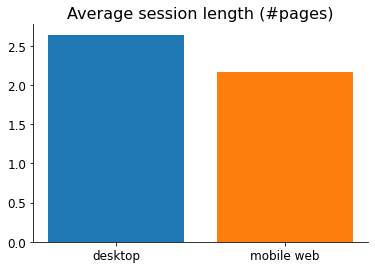

In [66]:
## this is interesting: it suggests that the different between mobile and desktop is in the tail
cmap = plt.get_cmap('tab10')
yavg = []
ystdev = []
ysterr = []
cols = df_tmp.columns
i = 0

fig = plt.figure()
ax = fig.add_subplot(111)
for col in cols:
    df_ = df_tmp[col].dropna()
    x = df_.index.astype(int)
    y = df_.values.astype(int)
    N = np.sum(y)
    s_avg = 1./N*np.sum(y*x)
    s_std = np.sqrt(1./(N-1)*np.sum(  y*(x-s_avg)**2  ))
    s_stderr = s_std/np.sqrt(N)
    yavg+=[s_avg]
    ystdev+=[s_std]
    ysterr+=[s_stderr]
    ax.bar([i],[s_avg],yerr=[s_stderr],label=col)

    i+=1
ax.set_xticks(np.arange(len(cols)))
ax.set_xticklabels(cols)
ax.set_title('Average session length (#pages)')

#### Distribution of session lengths

The fraction of sessions for each group that has a specific length.

The mobile has an increased fraction of sessoion-length=1 compared to desktop and slightly smaller fraction of all sessions of length=2. Otherwise the distribution look fairly similar.

Between 60 and 70% of sessions are of length=1, around 10% are of length 2, and so forth.

Text(0, 0.5, 'P(x)')

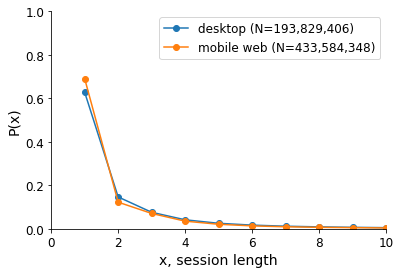

In [67]:
cols = df_tmp.columns
for col in cols:
    df_ = df_tmp[col].dropna()
    x = df_.index.astype(int)
    y = df_.values.astype(int)
    N = np.sum(y)
    p = y/N
    plt.plot(x,p,label='{0} (N={1:,})'.format(col,N),marker='o')
plt.legend()
plt.xlim(0,10)
plt.ylim(0,1)
plt.xlabel('x, session length')
plt.ylabel('P(x)')

#### Cumulative distribution to reveal more fine-grained differences

For each group we show the cumulative distribution, i.e. the fraction of sessions that are longer than x. For example only around 20-30% are longer than only 1 pageview. 

- still, around 10% of sessions are longer than 5 pageviews, and 1% of sessions are longer than 10 pageviews. This might seem small, but remember that in absolute terms we are still talking about 10M sessions that are longer than 5 pageviews and 1M sessions that are longer than 10 pageviews taking into account the ~100M sessions for 1 week of enwiki.
- we see that the curve for mobile is below the curve for desktop from the very start revealing that mobile has more sessions of length 1. 
- however, the difference increases for larger values of session lengths. This means that the difference between desktop and mobile becomes more pronounced for longer sessions. The fraction of sessions that are longer than 20 pageviews is 2 times as large for desktop as it is for mobile (see the next plot). This suggests that power users with many pageviews are more common among desktop-readers than mobile readers.




Note that this is a log-log-plot to capture that both session-length and number of sessions cover so many orders of magnitude.



/srv/home/mgerlach/venv_custom/venv_wmfdata/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  


Text(0, 0.5, 'P(s>x)')

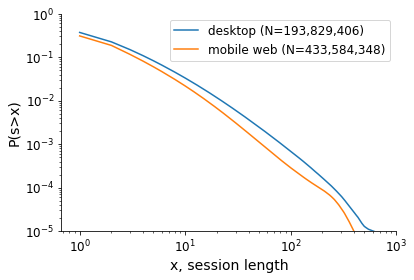

In [104]:
cols = df_tmp.columns
for col in cols:
    df_ = df_tmp[col].dropna()
    x = df_.index.astype(int)
    y = df_.values.astype(int)
    N = np.sum(y)
    p = y/N
    cdf = 1-np.cumsum(p)
    plt.plot(x,cdf,label='{0} (N={1:,})'.format(col,N))
plt.legend()
plt.yscale('log')
plt.xscale('log')

plt.xlim(0,1000)
plt.ylim(0.00001,1)
plt.xlabel('x, session length')
plt.ylabel('P(s>x)')

#### ratio between the cumulative distributions

In [79]:
df_tmp2 = 1.-(df_tmp.fillna(0)/df_tmp.sum(axis=0)).cumsum()

(0.0, 3.0)

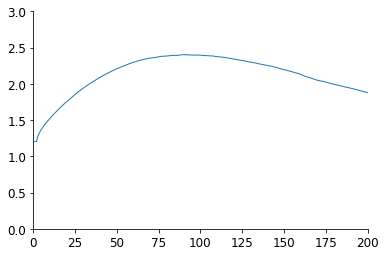

In [100]:
Z = df_tmp2['desktop']/df_tmp2['mobile web']
x = np.array(Z.index).astype(int)
# y = np.log(Z.values)
y = np.array(Z.values).astype(float)

plt.plot(x,y,lw=1)
# plt.yscale('log')
# plt.xscale('log')

plt.xlim(0,200)
plt.ylim(-1,1)
plt.ylim(0,3)

# plt.ylim(0.00001,1)
# plt.xlabel('x, session length')
# plt.ylabel('P(s>x)')

## Analysis: Session-length vs topic

We calculate the average and standard error of the mean of the lengths of sessions conditioning on the topic (we consider the topic of the first pageview in the session).

- as we saw before, desktop sessions are about half to one pageview longer than mobile sessions across all topics
- session lengths varies substantially across topics,

  - Culture.linguistics and Culture.sports have the largest average for desktop (~4)
  - STEM-related topics such as STEM.mathematics have shortest session length (~2 for desktop)
  
This is likely related to information needs and motivation by the reader. 
 
  
  

In [60]:
df_tmp = (
    sessions_len_df
 .groupBy('topic_start')
 .pivot('access_method')
 .agg( 
     F.avg(F.col('session_length')).alias('mean'), 
     F.stddev(F.col('session_length')).alias('std'),
     F.count(F.col('session_length') ).alias('N')
 )
).toPandas()
df_tmp.head()

,topic_start,desktop_mean,desktop_std,desktop_N,mobile web_mean,mobile web_std,mobile web_N
0,Culture.Philosophy_and_religion,2.453213,6.551017,2417696,1.886818,4.389120,6024641
1,Culture.Media.Films,2.925774,7.246797,6610845,2.617395,5.542393,16291031
2,Culture.Visual_arts.Fashion,2.391441,6.609679,228655,1.963926,4.647644,513169
3,Culture.Media.Books,2.368093,5.411582,296509,1.959990,4.619826,566482
4,Culture.Visual_arts.Visual_arts*,2.199693,6.499511,1040680,1.865505,5.013314,1509362


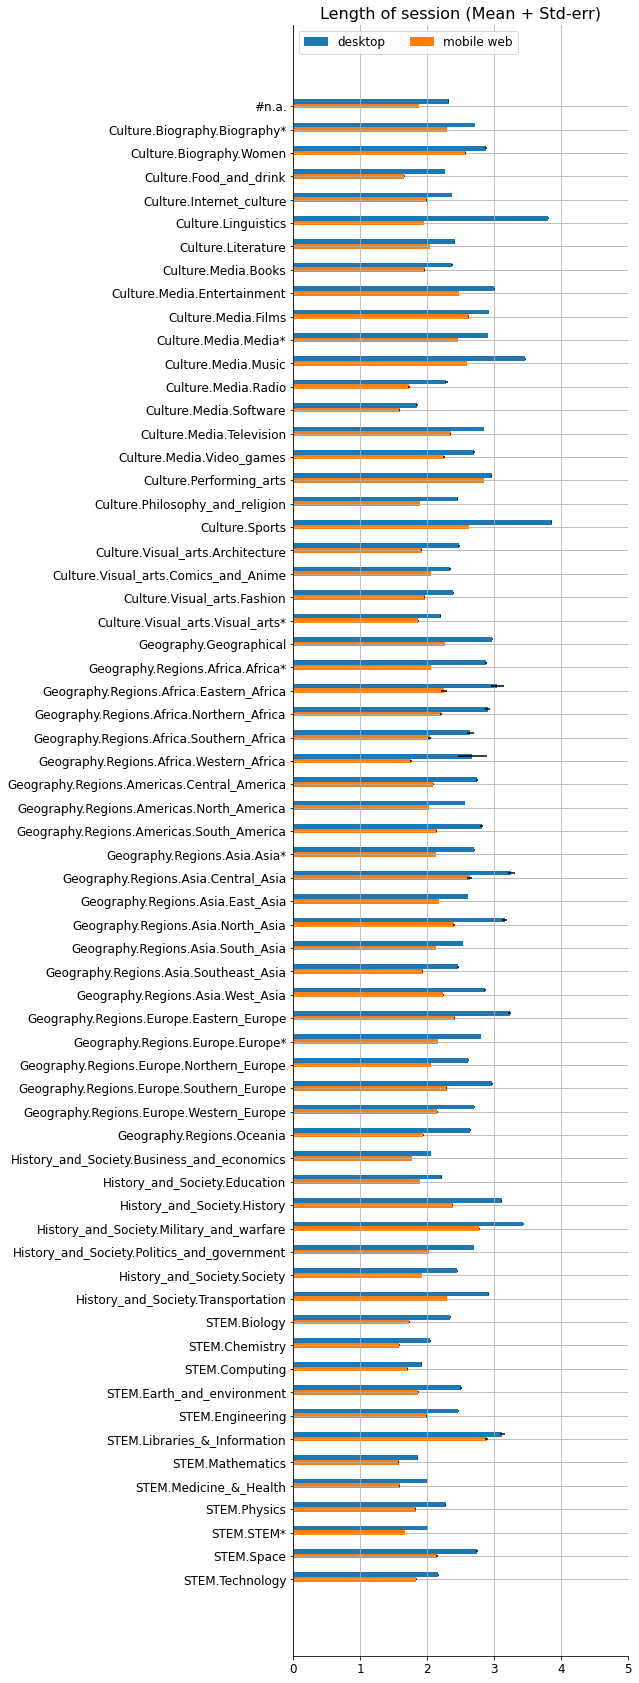

In [61]:
df_tmp = df_tmp.sort_values(by='topic_start')
fig, ax = plt.subplots(1, 1 ,figsize=(6,30 ))
list_am = ['desktop','mobile web']

for i_am,am in enumerate(list_am):
    arr1 = np.array(df_tmp.loc[:,'topic_start'])[::-1]
    arr2_mu = np.array(df_tmp.loc[:,'%s_mean'%am])[::-1]
    arr2_std = np.array(df_tmp.loc[:,'%s_std'%am])[::-1]
    arr2_N = np.array(df_tmp.loc[:,'%s_N'%am])[::-1]
    arr2_serr = arr2_std/np.sqrt(arr2_N)

    h = -0.2*(i_am-1)
    x = np.arange(len(arr1))+h
    y = arr2_mu

    ax.barh(x,y,xerr=arr2_serr,height=0.2,label=am)

x_min,x_max = 0.,5
ax.set_xlim(x_min,x_max)
ax.set_yticks(np.arange(len(arr1)))
ax.set_yticklabels(arr1)#,rotation=30,ha='right')


ax.set_title('Length of session (Mean + Std-err)')
ax.grid(True)
ax.legend(loc='upper left',ncol=3)

## Analysis: Session-length vs Geo-location

We compare session lengths vs continents as it is more coarse than countries.

Surprisingly, we do not find strong differences.


In [62]:
df_tmp = (
    sessions_len_df
 .groupBy('continent')
 .pivot('access_method')
 .agg( 
     F.avg(F.col('session_length')).alias('mean'), 
     F.stddev(F.col('session_length')).alias('std'),
     F.count(F.col('session_length') ).alias('N')
 )
).toPandas()
df_tmp.head()

,continent,desktop_mean,desktop_std,desktop_N,mobile web_mean,mobile web_std,mobile web_N
0,Antarctica,2.666667,3.542934,141,3.142857,4.159885,84
1,North America,2.726004,7.179103,87088433,2.240457,5.831213,209427886
2,Asia,2.298036,5.650160,33787580,2.017237,3.850084,97824424
3,Africa,2.055176,5.071472,3479187,1.980528,4.515389,12807892
4,South America,2.492384,6.318988,4778772,2.077572,4.843324,5168452


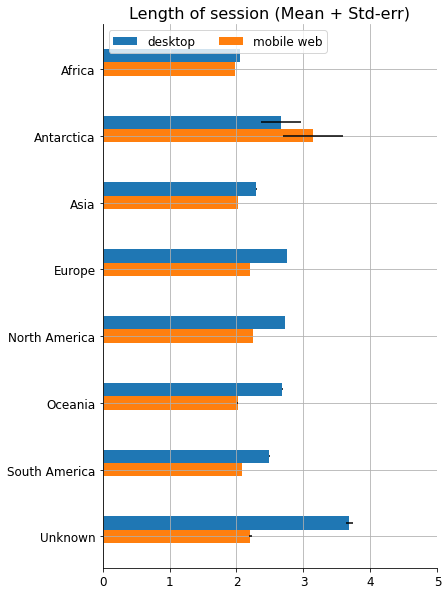

In [63]:
df_tmp = df_tmp.sort_values(by='continent')
fig, ax = plt.subplots(1, 1 ,figsize=(6,10 ))
list_am = ['desktop','mobile web']

for i_am,am in enumerate(list_am):
    arr1 = np.array(df_tmp.loc[:,'continent'])[::-1]
    arr2_mu = np.array(df_tmp.loc[:,'%s_mean'%am])[::-1]
    arr2_std = np.array(df_tmp.loc[:,'%s_std'%am])[::-1]
    arr2_N = np.array(df_tmp.loc[:,'%s_N'%am])[::-1]
    arr2_serr = arr2_std/np.sqrt(arr2_N)

    h = -0.2*(i_am-1)
    x = np.arange(len(arr1))+h
    y = arr2_mu

    ax.barh(x,y,xerr=arr2_serr,height=0.2,label=am)

x_min,x_max = 0.,5
ax.set_xlim(x_min,x_max)
ax.set_yticks(np.arange(len(arr1)))
ax.set_yticklabels(arr1)#,rotation=30,ha='right')


ax.set_title('Length of session (Mean + Std-err)')
ax.grid(True)
ax.legend(loc='upper left',ncol=3)

## Analysis: Session length (unique pages)

repaeting the analysis about the difference between mobile and desktop if we consider only unique pages within a session. For example, the session [1,2,1] would be 3 pageviews, however, there are only 2 unique pageviews, so in this case we count session-length=2.

The previous results do not change.

In [55]:
df_tmp = (
    sessions_len_df
    .groupBy('access_method')
    .pivot('session_length_unique')
    .count()
).toPandas()
df_tmp.head()

,access_method,1,2,3,4,5,6,7,8,9,...,1877,1886,1919,2046,2091,2213,2330,2480,2545,2760
0,desktop,121691818,32252251,13822047,7390976,4504990,2982209,2092898,1535490,1163876,...,1.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,1.0
1,mobile web,299377593,65473600,25743143,13087123,7723284,4994960,3450839,2501978,1874145,...,NaN,1.0,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN


In [56]:
df_tmp = df_tmp.set_index('access_method').transpose()
df_tmp.head()

access_method,desktop,mobile web
1,121691818.0,299377593.0
2,32252251.0,65473600.0
3,13822047.0,25743143.0
4,7390976.0,13087123.0
5,4504990.0,7723284.0


Text(0.5, 1.0, 'Average session length (#pages)')

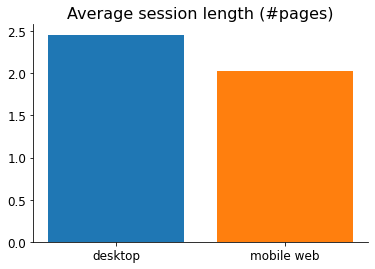

In [57]:
## this is interesting: it suggests that the different between mobile and desktop is in the tail
cmap = plt.get_cmap('tab10')
yavg = []
ystdev = []
ysterr = []
cols = df_tmp.columns
i = 0

fig = plt.figure()
ax = fig.add_subplot(111)
for col in cols:
    df_ = df_tmp[col].dropna()
    x = df_.index.astype(int)
    y = df_.values.astype(int)
    N = np.sum(y)
    s_avg = 1./N*np.sum(y*x)
    s_std = np.sqrt(1./(N-1)*np.sum(  y*(x-s_avg)**2  ))
    s_stderr = s_std/np.sqrt(N)
    yavg+=[s_avg]
    ystdev+=[s_std]
    ysterr+=[s_stderr]
    ax.bar([i],[s_avg],yerr=[s_stderr],label=col)

    i+=1
ax.set_xticks(np.arange(len(cols)))
ax.set_xticklabels(cols)
ax.set_title('Average session length (#pages)')

Text(0, 0.5, 'P(x)')

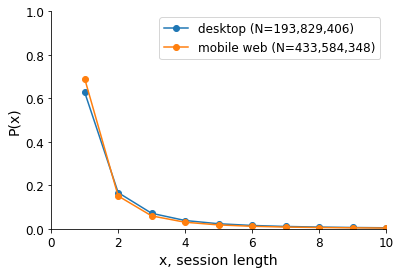

In [58]:
cols = df_tmp.columns
for col in cols:
    df_ = df_tmp[col].dropna()
    x = df_.index.astype(int)
    y = df_.values.astype(int)
    N = np.sum(y)
    p = y/N
    plt.plot(x,p,label='{0} (N={1:,})'.format(col,N),marker='o')
plt.legend()
plt.xlim(0,10)
plt.ylim(0,1)
plt.xlabel('x, session length')
plt.ylabel('P(x)')

/srv/home/mgerlach/venv_custom/venv_wmfdata/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  


Text(0, 0.5, 'P(s>x)')

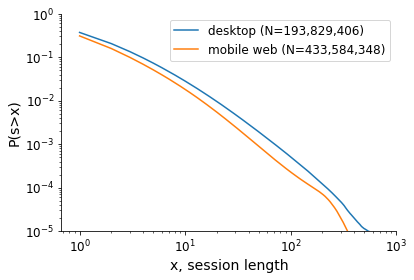

In [59]:
cols = df_tmp.columns
for col in cols:
    df_ = df_tmp[col].dropna()
    x = df_.index.astype(int)
    y = df_.values.astype(int)
    N = np.sum(y)
    p = y/N
    cdf = 1-np.cumsum(p)
    plt.plot(x,cdf,label='{0} (N={1:,})'.format(col,N))
plt.legend()
plt.yscale('log')
plt.xscale('log')

plt.xlim(0,1000)
plt.ylim(0.00001,1)
plt.xlabel('x, session length')
plt.ylabel('P(s>x)')